# Análisis de series de tiempo 

Las series de tiempo son una secuencia de observaciones indexadas por una variable temporal. Una de las aplicaciones más comunes del análisis de series de tiempo es la predicción de valores futuros utilizando datos históricos. Por ejemplo se desea predecir el valor de la medida en el siguiente minuto, día, mes, año basados en los datos recolectados en el/(los) minuto(s), día(s), mese(s) y años previo(s). 


![texto alternativo](https://cdn-images-1.medium.com/max/800/1*ScwIEwLmXPFhBP46QMpy_A.png)

## Series de tiempo como problema supervisado 

Un problema de análisis de series de tiempo puede ser transformado en un problema de aprendizaje supervisado tomando una **ventana** de  las *n* observaciones anteriores como los predictores y el valor actual como el valor objetivo o valor explicado. El ancho de la ventana *n* normalmente se explora como hiperparámetro. 

## Validación cruzada para series de tiempo

Un aspecto importante a tener en cuenta en el análisis de series de tiempo es que la selección de los conjuntos de validación y entrenamiento para la validación cruzada (*Cross-validation*) no puede ser aleatorio como se realiza en otros problemas de machine learning supervisado donde la secuencia y el tiempo no se toman en cuenta. En el análisis de series de tiempo estamos interesados en predecir un valor en el futuro, de esta manera los datos de validación para series de tiempo siempre deben ocurrir después de los datos de entrenamiento. Existen dos esquemas de validación cruzada para series de tiempo **sliding-window** y **Forward chaining validation** que pueden ser usados para la validación cruzada de series de tiempo.

![texto alternativo](https://cdn-images-1.medium.com/max/800/1*h6HaTi1DKsNqEUjdECQV0A.png)



## Demostración 

Ahora realizaremos la predicción para el dataset S&P 500, que es el indice de capitalización de Standard & Poor's compuesto por las 500 empresas  pricipales que cotizan acciones en los mercados NYSE y NASDAQ, estos datos fueron tomados de la siguiente dirección https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC. La siguiente celda descarga el archivo:

In [1]:
!wget -O GSPC.csv "https://drive.google.com/uc?export=download&id=10BJ7F4_YxB1F82QOIt2qv-Cew7fzu-Le"

--2019-06-07 01:10:29--  https://drive.google.com/uc?export=download&id=10BJ7F4_YxB1F82QOIt2qv-Cew7fzu-Le
Resolving drive.google.com (drive.google.com)... 74.125.141.113, 74.125.141.102, 74.125.141.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.141.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-2c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9c238k6lk565fkk9c0sonji9anogav4k/1559865600000/13121894196654599000/*/10BJ7F4_YxB1F82QOIt2qv-Cew7fzu-Le?e=download [following]
--2019-06-07 01:10:34--  https://doc-04-2c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9c238k6lk565fkk9c0sonji9anogav4k/1559865600000/13121894196654599000/*/10BJ7F4_YxB1F82QOIt2qv-Cew7fzu-Le?e=download
Resolving doc-04-2c-docs.googleusercontent.com (doc-04-2c-docs.googleusercontent.com)... 74.125.141.132, 2607:f8b0:400c:c06::84
Connecting to doc-04-2c-docs.googleusercontent.com (doc-04

#### Iniciamos por la carga de datos 

Vamos a cargar el dataset en un pandas dataframe. Y a visualizar sus primeras 4 filas.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv("GSPC.csv")
df.head(4)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1995-01-01,459.209991,471.359985,457.200012,470.420013,470.420013,6852060000
1,1995-02-01,470.420013,489.190002,469.290009,487.390015,487.390015,6330100000
2,1995-03-01,487.390015,508.149994,479.700012,500.709991,500.709991,7792400000
3,1995-04-01,500.700012,515.289978,500.200012,514.710022,514.710022,6307030000


El dataset cuenta con una columna que muestra la fecha (Date) calculada el primer día de cada mes, el valor del indice a la apertura (Open) del mercado, el valor máximo alcanzado durante la jornada (High), el valor mínimo alcanzado durante la jornada (Low), y el valor del indice al final de la jornada (Close), el valor de cierre ajustado (Adj Close) y volumen de transacciones (Volume).

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 7 columns):
Date         267 non-null object
Open         267 non-null float64
High         267 non-null float64
Low          267 non-null float64
Close        267 non-null float64
Adj Close    267 non-null float64
Volume       267 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 14.7+ KB


Antes de continuar con el análisis debemos establecer las fechas como índice del data frame. 

In [5]:
df = df.set_index("Date")
df.head(4)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1995-01-01,459.209991,471.359985,457.200012,470.420013,470.420013,6852060000
1995-02-01,470.420013,489.190002,469.290009,487.390015,487.390015,6330100000
1995-03-01,487.390015,508.149994,479.700012,500.709991,500.709991,7792400000
1995-04-01,500.700012,515.289978,500.200012,514.710022,514.710022,6307030000


Vamos a visualizar la serie de los valores del índice.

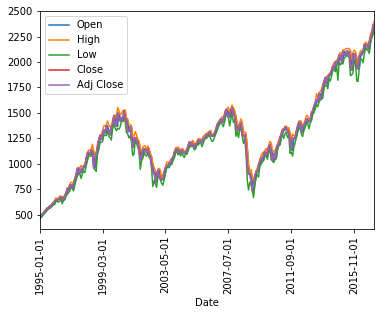

In [6]:
df[["Open", "High", "Low", "Close", "Adj Close"]].plot(rot=90)

Visualizamos la serie de apertura que será el valor que predeciremos.

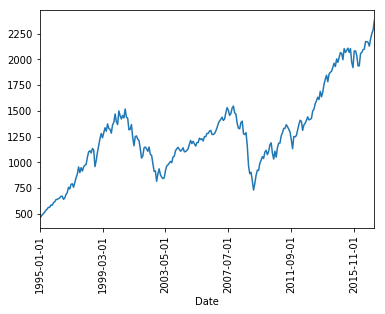

In [7]:
df["Open"].plot(rot=90)

Vamos a construir el dataset, las features serán las n observaciones previas y el valor a predecir será el valor actual. Vamos a iniciar con una ventana de tiempo de 3 observaciones.

In [0]:
# Función para obtener las ventanas de timepo
def sliding_time(ts, window_size=1):
  y = []
  f = []
  for i in range(window_size, ts.shape[0]):
    y.append(ts[i])
    f.append(ts[i-window_size:i])
    
  return np.array(f), np.array(y)  

In [9]:
# Convertimos el pandas dataframe a numpy array.
data = df["Open"].values
data.shape

(267,)

In [0]:
X, y = sliding_time(data, window_size=3) 

In [12]:
print("Número de ejemplos de entrenamiento {}, número de features {}".format(X.shape[0], X.shape[1]))
print("Número de valores a predecir {}".format(y.shape))

Número de ejemplos de entrenamiento 264, número de features 3
Número de valores a predecir (264,)


Como pudimos observar el número de ejemplos son 260, tres ejemplos menos que en la serie original, esto es debido a que las primeras siete muestras no cuentan con features suficientes para ser incluidas dentro del conjunto de datos para el entrenamiento de los modelos. 

#### Partición de los datos para train y test

Como se mencionó previamente para realizar la partición train y test se debe tomar en cuenta la temporalidad de la serie para ello utilizaremos la función TimeSeriesSplit de scikit-learn.

In [0]:
from sklearn.model_selection import TimeSeriesSplit

In [0]:
# Definimos el número de splits para realizar cross-validation
tsp = TimeSeriesSplit(n_splits=2)

In [17]:
# La partición nos devuelve los indices de train y test
split1_idx, split2_idx = tsp.split(X, y)
print(split1_idx)
print(split2_idx)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87]), array([ 88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175]))
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  1

In [0]:
# Indexamos para obtener los conjuntos de train y test 
X_train = X[split2_idx[0]]
y_train = y[split2_idx[0]]
X_test = X[split2_idx[1]]
y_test = y[split2_idx[1]]

In [19]:
# Verificamos los tamaños de train, validation y test
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(176, 3)
(176,)
(88, 3)
(88,)


Visualizamos los datos de entrenamiento, validación y prueba:

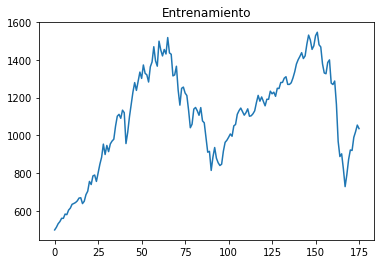

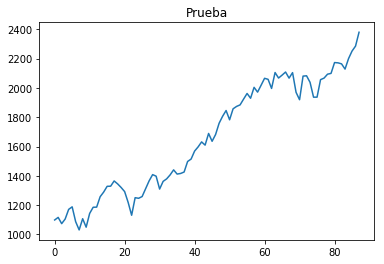

In [20]:
plt.plot(y_train)
plt.title("Entrenamiento")
plt.show()
plt.plot(y_test)
plt.title("Prueba")
plt.show()

#### Modelo de regression lineal.

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
reg = LinearRegression()

In [23]:
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# Realizamos la predicción 
y_pred = reg.predict(X_test)

Calculamos el desempeño de este modelo de regressión lineal.

In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

In [26]:
print("Test Mean Squared Error: {}".format(mean_squared_error(y_test, y_pred)))
print("Test Mean Absolute Error: {}".format(mean_absolute_error(y_test, y_pred)))
print("Test Mean squared log error: {}".format(mean_squared_log_error(y_test, y_pred)))

Test Mean Squared Error: 4025.28988280473
Test Mean Absolute Error: 51.56311582184233
Test Mean squared log error: 0.0016009758844823258


#### Visualizamos los resultados 

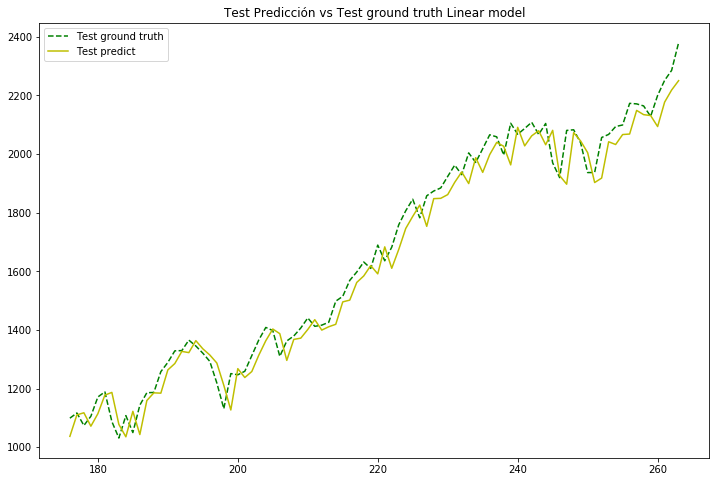

In [27]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_test, "g--", 
         label="Test ground truth")
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_pred, "y", 
         label="Test predict")
plt.title("Test Predicción vs Test ground truth Linear model")
plt.legend()

Text(0, 0.5, 'Predicho')

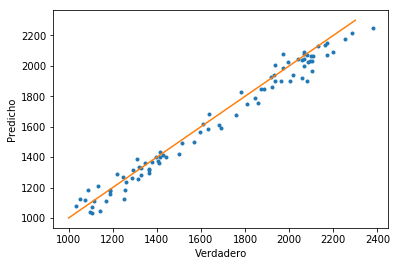

In [28]:
plt.plot(y_test, y_pred, '.')
plt.plot([1000,2300], [1000,2300])
plt.xlabel("Verdadero")
plt.ylabel("Predicho")

#### Support vector regression
Ahora realizamos la regressión utilizando la misma partición y el algoritmo support vector regressor.

In [0]:
from sklearn.svm import SVR

In [31]:
svr = SVR(C=4, kernel="linear")
svr.fit(X_train, y_train)

SVR(C=4, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

Evaluamos el modelo.

In [0]:
y_pred = svr.predict(X_test)

In [33]:
y_pred = svr.predict(X_test)
print("Test Mean Squared Error: {}".format(mean_squared_error(y_test, y_pred)))
print("Test Mean Absolute Error: {}".format(mean_absolute_error(y_test, y_pred)))
print("Test Mean squared log error: {}".format(mean_squared_log_error(y_test, y_pred)))

Test Mean Squared Error: 3342.069985160294
Test Mean Absolute Error: 46.79629687544527
Test Mean squared log error: 0.0014040417806229387


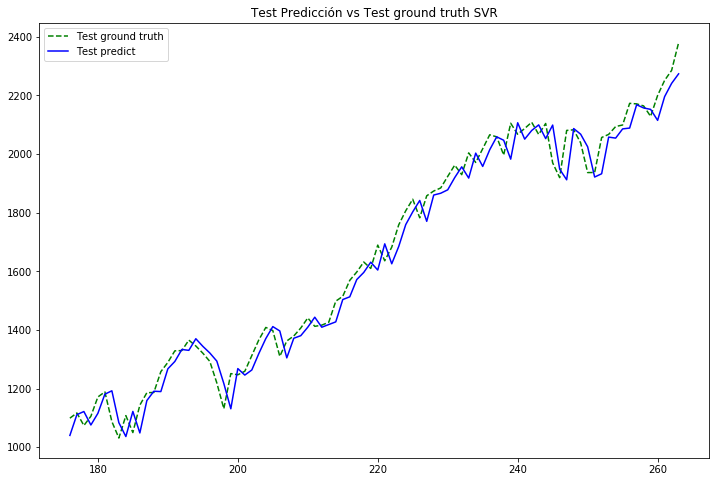

In [34]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_test, "g--", 
         label="Test ground truth")
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_pred, "b", 
         label="Test predict")
plt.title("Test Predicción vs Test ground truth SVR")
plt.legend()

Text(0, 0.5, 'Predicho')

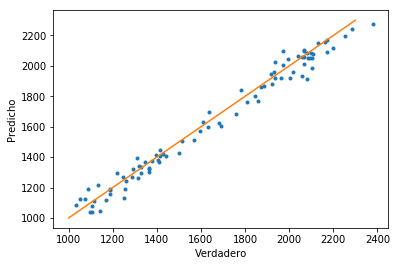

In [35]:
plt.plot(y_test, y_pred, '.')
plt.plot([1000,2300], [1000,2300])
plt.xlabel("Verdadero")
plt.ylabel("Predicho")

#### Random forest
Ahora realizamos la regresión con un random forest con 20 estimadores.

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [0]:
rr = RandomForestRegressor(n_estimators=20)

In [39]:
rr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [40]:
y_pred = rr.predict(X_test)
print("Test Mean Squared Error: {}".format(mean_squared_error(y_test, y_pred)))
print("Test Mean Absolute Error: {}".format(mean_absolute_error(y_test, y_pred)))
print("Test Mean squared log error: {}".format(mean_squared_log_error(y_test, y_pred)))

Test Mean Squared Error: 152751.70737108964
Test Mean Absolute Error: 289.7668938250001
Test Mean squared log error: 0.049603846808728716


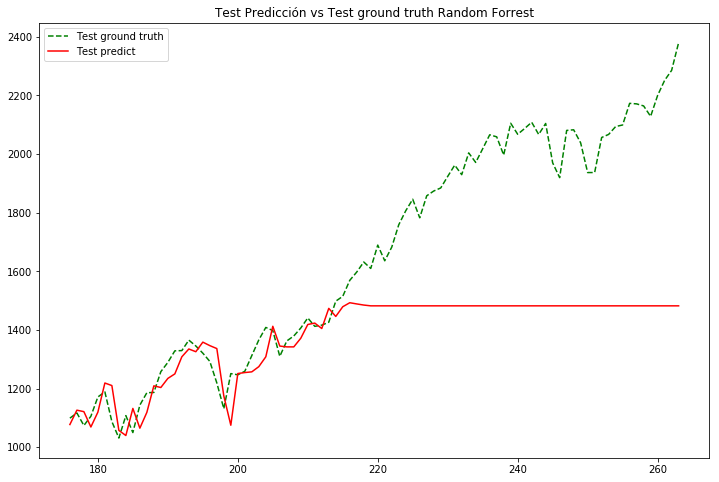

In [41]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_test, "g--", 
         label="Test ground truth")
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_pred, "r", 
         label="Test predict")
plt.title("Test Predicción vs Test ground truth Random Forrest")
plt.legend()

Text(0, 0.5, 'Predicho')

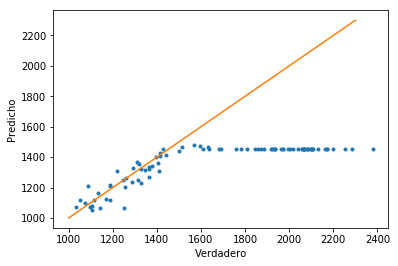

In [0]:
plt.plot(y_test, y_pred, '.')
plt.plot([1000,2300], [1000,2300])
plt.xlabel("Verdadero")
plt.ylabel("Predicho")

Ahora realizamos la regression con una red neuronal multicapa.

## Refrencias 

* https://towardsdatascience.com/time-series-machine-learning-regression-framework-9ea33929009a
* https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424
